In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PCA import PCA_Component

data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

### Plot residuals for 1 signal for different number of n_components

31


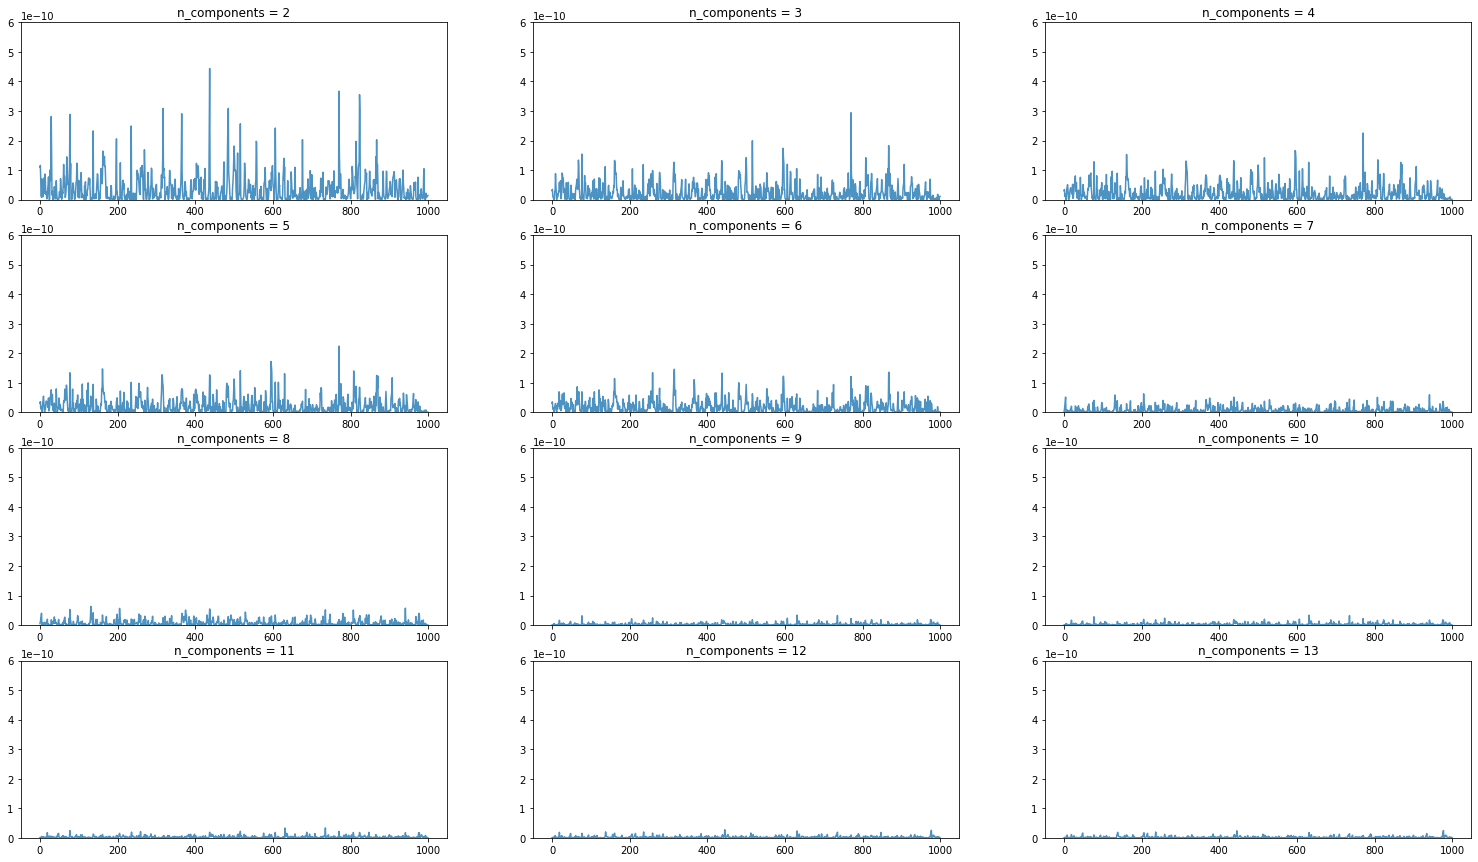

In [2]:

signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
X = data_1[signals].to_numpy()

signal_to_PLOT = signals.index('P_J280') # selected P_J280 because shows importance
print(signal_to_PLOT)
pca = PCA_Component()
pca.set_X(X)

f, axs = plt.subplots(4,3,figsize =(26, 15))
for i in range(12):
    n_components = i+2 # start with 2 components
    pca.PCA_fit_transform(n_components)
    R = pca.calculate_residual(X)
    s = R[:,signal_to_PLOT]

    axs[int(i/3), i%3].set_title("n_components = " + str(n_components))
    axs[int(i/3), i%3].plot(range(1000), s[0:1000], alpha = 0.8)
    axs[int(i/3), i%3].set_ylim((0,6e-10)) # consistent y-axis


### Choosing `n_components`
We will use the mean and standard deviation of anomaly score (the probability of a row being an anomaly) to choose. The anomaly score should be low for normal data and high for data we know is outlier. Moreover, we can split `data 2` in two parts (inlier and outlier) to see that it firs the inliers as normal data.

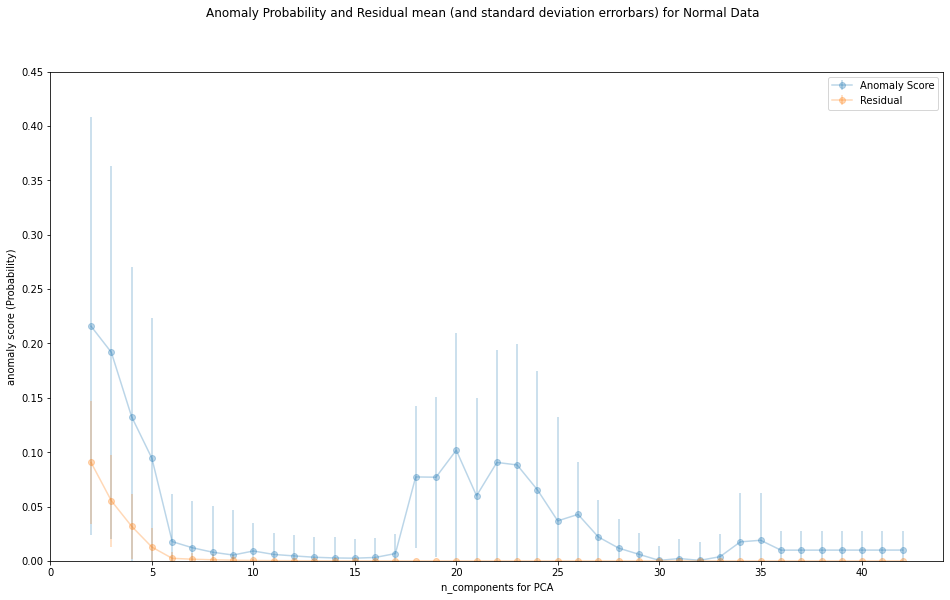

In [3]:
pca = PCA_Component()
pca.set_X(X)

per_n_components = []
per_n_components_R = []

for n_components in range(2, 43): # try all possible n_components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(X)
    per_n_components.append(score)

    R = pca.calculate_residual(X)
    R = np.sum(R, axis=1) # sum up residuals for all signals
    per_n_components_R.append(R)
    
mean_ = np.mean(per_n_components, axis=1)
std_ = np.std(per_n_components, axis=1)
mean_R = np.mean(per_n_components_R, axis=1)
std_R= np.std(per_n_components_R, axis=1)

fig = plt.figure(figsize=(16, 9))
fig.suptitle("Anomaly Probability and Residual mean (and standard deviation errorbars) for Normal Data")
plt.errorbar(x=range(2, 43), y=mean_, yerr=std_, fmt='o-', alpha = 0.3, label="Anomaly Score")
plt.errorbar(x=range(2, 43), y=mean_R, yerr=std_R, fmt='o-', alpha = 0.3, label="Residual")
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.ylim((0,0.45)) # consistent y-axis
plt.legend()
plt.show()

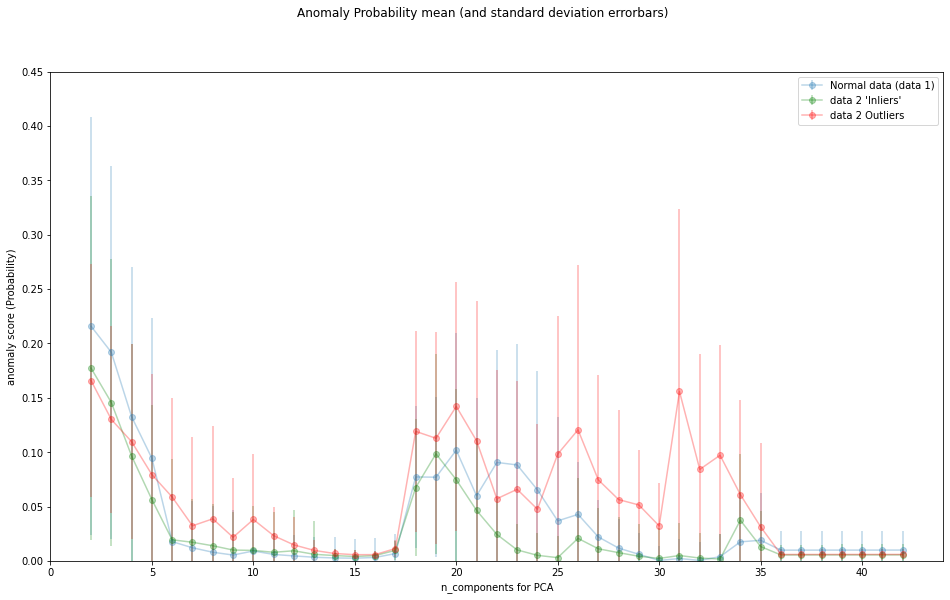

In [4]:
pca = PCA_Component()
pca.set_X(X) # fit for normal data
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]
Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]

per_n_components_outlier = []
per_n_components_inlier = []
for n_components in range(2, 43): # try all possible n_components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(Z_outliers)
    per_n_components_outlier.append(score)
    score = pca.anomaly_score(Z_inliers)
    per_n_components_inlier.append(score)
    
mean_outlier = np.mean(per_n_components_outlier, axis=1)
std_outlier = np.std(per_n_components_outlier, axis=1)
mean_inlier = np.mean(per_n_components_inlier, axis=1)
std_inlier = np.std(per_n_components_inlier, axis=1)


fig = plt.figure(figsize=(16, 9))
fig.suptitle("Anomaly Probability mean (and standard deviation errorbars)")
plt.errorbar(x=range(2, 43), y=mean_, yerr=std_, fmt='o-', alpha=0.3, label="Normal data (data 1)")
plt.errorbar(x=range(2, 43), y=mean_inlier, yerr=std_inlier, fmt='o-', alpha=0.3, c='g', label="data 2 'Inliers'")
plt.errorbar(x=range(2, 43), y=mean_outlier, yerr=std_outlier, fmt='o-', alpha=0.3,c='r', label="data 2 Outliers")
plt.ylim((0,0.45)) # consistent y-axis
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.legend()
plt.show()

### Select `n_components = 10`
This is because it models the normal data (entire data_1 and data_2 inliers) well with very low residual error AND it shows high anomaly score for data we know is outlier while generalising using less number of components.

### Abnormalities in training data

**Q. Do you see large abnormalities in the trainingdata?**

In the above plot it is quite visible that outlier data has higher probability of being tagged anomalous. We see at `n_components = 31` this observation is most prominant.

**Q. Can you explain why these occur?**

This is because the outlier points (attacks) have abnormal behaviour and their inverse PCA mapping is very erroneous and thus have higher residual. This is because these points have high variance for principal components which usually shouldn't.

**Q. Describe the kind of anomalies you can detect using PCA.**

We can detect outlier points which have a different variance than the regular distribution in the direction of the principal components.

## Task 6 material

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PCA import PCA_Component

data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

In [6]:

signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
import datetime
test_data['ATT_FLAG'] = pd.Series(np.zeros(test_data.shape[0])) # default 0 (no-attack)

# start setting values
attack_times = [
    [pd.Timestamp("2017-01-16T09"), pd.Timestamp("2017-01-19T06")],
    [pd.Timestamp("2017-01-30T08"), pd.Timestamp("2017-02-02T00")],
    [pd.Timestamp("2017-02-09T03"), pd.Timestamp("2017-02-10T09")],
    [pd.Timestamp("2017-02-12T01"), pd.Timestamp("2017-02-13T07")],
    [pd.Timestamp("2017-02-24T05"), pd.Timestamp("2017-02-28T08")],
    [pd.Timestamp("2017-03-10T14"), pd.Timestamp("2017-03-13T21")],
    [pd.Timestamp("2017-03-25T20"), pd.Timestamp("2017-03-27T01")]
]

for times in attack_times:
    indexes = np.where(test_data['DATETIME'].between(times[0], times[1], inclusive=True))[0]
    test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)

X = data_1[signals].to_numpy()
test_X = test_data[signals].to_numpy()
test_Y = test_data['ATT_FLAG'].to_numpy()

In [7]:
from PCA import PCA_Component
from metrics import run_metrics

pca = PCA_Component()
pca.set_X(X)
n_components = 10
pca.PCA_fit_transform(n_components)
y_pred = pca.classify(test_X)
result = run_metrics(test_Y, y_pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [9]:
result

{'false_pos_rate': array([0.        , 0.26622662, 1.        ]),
 'true_pos_rate': array([0.        , 0.56826568, 1.        ]),
 'precision_curve': array([0.12972714, 0.24137931, 1.        ]),
 'recall_curve': array([1.        , 0.56826568, 0.        ]),
 'accuracy': 0.7123025370990905,
 'precision': 0.2413793103448276,
 'recall': 0.5682656826568265,
 'f1': 0.3388338833883388,
 'auc': 0.6510195299972801,
 'tn': 1334,
 'tp': 154,
 'fn': 117,
 'fp': 484}